# Predicting Hotel Cancellations

## 🏨 Background

You are supporting a hotel with a project aimed to increase revenue from their room bookings. They believe that they can use data science to help them reduce the number of cancellations. This is where you come in! 

They have asked you to use any appropriate methodology to identify what contributes to whether a booking will be fulfilled or cancelled. They intend to use the results of your work to reduce the chance someone cancels their booking.

## The Data

They have provided you with their bookings data in a file called `hotel_bookings.csv`, which contains the following:

| Column     | Description              |
|------------|--------------------------|
| `Booking_ID` | Unique identifier of the booking. |
| `no_of_adults` | The number of adults. |
| `no_of_children` | The number of children. |
| `no_of_weekend_nights` | Number of weekend nights (Saturday or Sunday). |
| `no_of_week_nights` | Number of week nights (Monday to Friday). |
| `type_of_meal_plan` | Type of meal plan included in the booking. |
| `required_car_parking_space` | Whether a car parking space is required. |
| `room_type_reserved` | The type of room reserved. |
| `lead_time` | Number of days before the arrival date the booking was made. |
| `arrival_year` | Year of arrival. |
| `arrival_month` | Month of arrival. |
| `arrival_date` | Date of the month for arrival. |
| `market_segment_type` | How the booking was made. |
| `repeated_guest` | Whether the guest has previously stayed at the hotel. |
| `no_of_previous_cancellations` | Number of previous cancellations. |
| `no_of_previous_bookings_not_canceled` | Number of previous bookings that were canceled. |
| `avg_price_per_room` | Average price per day of the booking. |
| `no_of_special_requests` | Count of special requests made as part of the booking. |
| `booking_status` | Whether the booking was cancelled or not. |

Source (data has been modified): https://www.kaggle.com/datasets/ahsan81/hotel-reservations-classification-dataset

In [2]:
import pandas as pd
hotels = pd.read_csv("hotel_bookings.csv")
hotels.head(10)

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled
5,INN00006,2,0,0,2,Meal Plan 2,0,Room_Type 1,346,2018,9,13,Online,0,0,0,115.00,1,Canceled
6,INN00007,2,0,1,3,Meal Plan 1,0,Room_Type 1,34,2017,10,15,Online,0,0,0,107.55,1,Not_Canceled
7,INN00008,2,0,1,3,Meal Plan 1,0,Room_Type 4,83,2018,12,26,Online,0,0,0,105.61,1,Not_Canceled
8,INN00009,3,0,0,4,Meal Plan 1,0,Room_Type 1,121,2018,7,6,Offline,0,0,0,96.90,1,Not_Canceled
9,INN00010,2,0,0,5,Meal Plan 1,0,Room_Type 4,44,2018,10,18,Online,0,0,0,133.44,3,Not_Canceled


# 1 - Introduction - Exploratory analysis

Before starting, I would like to summarize the information that we are looking for: 

* What factors affect whether customers cancel their booking?
* Are cancellations more likely during weekends?
* Which general recommendations for the hotel can you make?

I started to learn data science 2 months ago, so there might be some issues regarding the study.

## 1.1. Remove NaN values / Rearrange and convert types

The data is going to be analyzed in order to verify the numbers of missing values and perform actions accordingly (imputation, fill with 0 or drop features). All the necessary packages and functions will be added before starting the analysis

In [3]:
# Imports
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import date
import re
from scipy.stats import iqr

# Functions
def give_na (df, normalize):
    ''' Give the sum of NaN inside the dataFrame
      Args:
          df (pandas.core.frame.DataFrame): DataFrame
          normalize (bool): Give the frequency value
      Return:
          pandas.core.series.Series: Informations about the count of all NaN in each column which contains NaN of the selected dataFrame
      '''
    new_df = pd.DataFrame()
    for col in df.columns:
        if df[col].isna().any():
            new_df[col] = df[col]
    if (normalize == True):
        return round(new_df.isna().sum()/len(df), 3)
    else:
        return new_df.isna().sum()

def create_date_from_df_col (df, year_col, month_col, day_col, new_col): 
    ''' Recover year, value and date columns as int or str and returns a formatted pandas series with string as %Y-%m-%d format
       Args:
            df (DataFrame): DataFrame
           year_col (str): year column of the data in str or int
           month_col(str): month column of the data in str or int
           day_col(str): day column of the data in str or int
       Return:
           class pandas.core.series.Series with newly created column of type str
       '''
    col_list = [year_col, month_col, day_col]
    df.rename(columns={year_col: 'year', month_col: 'month', day_col: 'day'}, inplace=True)
    # Combine year, month, and day columns into a single column with a datetime format
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']], format='%Y-%m-%d',  errors='coerce')
    # Convert datetime column to a string in the desired format
    return df


def createCatPlot (data, title, x, y, col, hue, kind):
    ''' Create a boxplot figure for all columns of the data except if only float types in specified
    Args:
        data (DataFrame)
        x (string): feature from data used on x-axis
        yl (string): feature from data used on y-axis
        hue (string): Parameter from catplot function in seaborn
        kind (string): type of catplot
        col (string): feature from column for subplots

    Return:
        void: The purpose of the function is to display the plot using plt.show.
    '''
    cat = sns.catplot(data=data, x=x, y=y, kind=kind, col=col ,hue=hue)
    cat.set_xticklabels(rotation=90)
    cat.fig.suptitle(title, y=1.05)
    plt.show()
 

Before cleaning : (36275, 19)
Types before conversion:  Booking_ID                               object
no_of_adults                              int64
no_of_children                            int64
no_of_weekend_nights                      int64
no_of_week_nights                         int64
type_of_meal_plan                        object
required_car_parking_space                int64
room_type_reserved                       object
lead_time                                 int64
arrival_year                              int64
arrival_month                             int64
arrival_date                              int64
market_segment_type                      object
repeated_guest                            int64
no_of_previous_cancellations              int64
no_of_previous_bookings_not_canceled      int64
avg_price_per_room                      float64
no_of_special_requests                    int64
booking_status                           object
dtype: object
Missing values bef

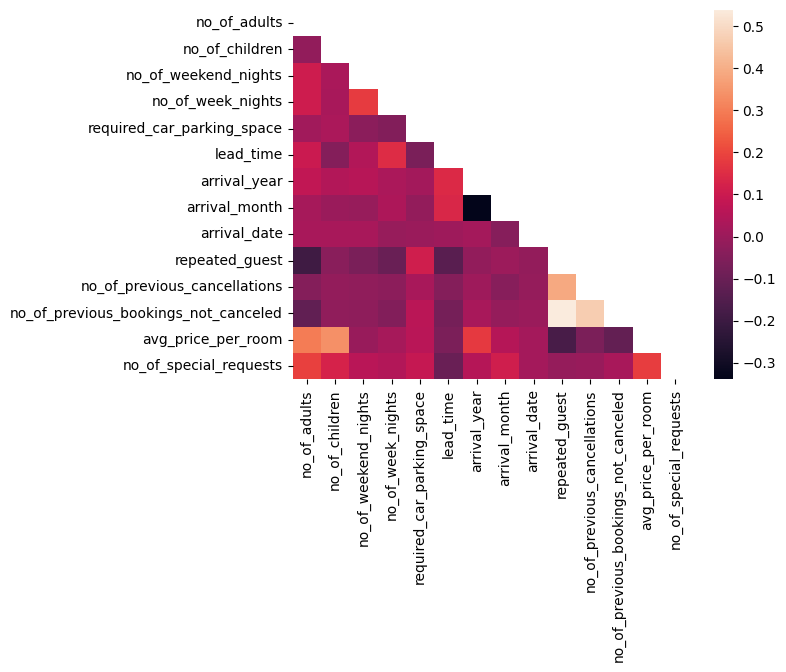

In [13]:
print('Before cleaning : {}'.format(hotels.shape))
print('Types before conversion: ', hotels.dtypes)
print('Missing values before cleaning: ', give_na(hotels, False))

# Type of meals null will be considerated as Not Selected option
hotels['type_of_meal_plan'] = hotels['type_of_meal_plan'].replace(np.nan, 'Not Selected')

# Assign a list for columns to fill with zero
col_fill_with_zero = ['no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights','required_car_parking_space', 'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled', 'no_of_special_requests', 'repeated_guest', ]
hotels[col_fill_with_zero] = hotels[col_fill_with_zero].replace(np.nan, 0)

hotels_num = hotels.select_dtypes(include=['int64', 'float64'])
hotels_corr=hotels_num.corr()
matrix = np.triu(hotels_corr)
sns.heatmap(hotels_corr, xticklabels=True, yticklabels=True,
            fmt='.1f', mask=matrix
           )

# Count of market_segment_type and room_type_reserved
print('Market segment type', hotels['market_segment_type'].value_counts(True, dropna=False))
print('room_type_reserved', hotels['room_type_reserved'].value_counts(True, dropna=False))
print('arrival year', hotels['arrival_year'].value_counts(False, dropna=False))

# Drop NA because occur only for less than 5% of the dataset

numeric_col = ['avg_price_per_room', 'lead_time']
hotels[numeric_col] = hotels[numeric_col].fillna(hotels[numeric_col].mean())
hotels.dropna(subset=['arrival_year', 'arrival_month', 'room_type_reserved', 'market_segment_type', 'arrival_date'], inplace=True)

# Convert types
for col in hotels.columns:
    if hotels[col].dtype == 'object' and col != 'Booking_ID':
        hotels[col] = hotels[col].astype('category')
    if (len(re.findall(r"arrival_",col)) > 0) or (len(re.findall(r"no_",col)) > 0):
        hotels[col] = hotels[col].astype('int')
    if ((col == 'repeated_guest') or (col == 'required_car_parking_space')):
        hotels[col] = hotels[col].astype('bool')

print('After cleaning: ', hotels.shape)
print('Types after conversion: ', hotels.dtypes)
print('Missing values after cleaning: ', give_na(hotels, False))

No correlation was found in the data except medium relationship between the repeated guest (0.5) and number of previous booking not cancelled which can be understood easily. A weak-medium relationship links the average price of a room and a number of adults.

For the missing values, it has been decided to drop in the columns that can't be replaced by 0 or numerical columns (average price and lead time). 3544 rows was removed which represents in total 10% of the dataset (all of the separated elements accounted for only less than 5%).

The types of the data was changed to match the real datatypes using the .astype() method. Some of the categorical variables have small occurrence (for example Room Type 3 in room_type_reserve with less than 0.02% frequency) and we will be changed to keep the most frequent categories.

Some further studies need to be implemented:
* Impact of the family
* Date
* Verify the room type and market sgment
* Bookings and repeated guests
* Number of bookings (Cancelled and Not Cancelled)
* Pricing impact

## 1.2. Data exploration / Visualizations


In [ ]:
# Impact on the family
print('There is {:.2f} % of booking cancelled'.format(hotels['booking_status'].value_counts(True).Canceled * 100))

hotels['family'] = np.where(hotels['no_of_children'] > 0, True, False)
count = hotels.groupby('family')['booking_status'].value_counts()

pie_data=[]
for val in count:
    pie_data.append(val)
labels = ['Not cancelled - Not Family', 'Cancelled - Not Family','Not cancelled - Family', 'Cancelled - Family']    

colors = sns.color_palette('RdBu')
plt.pie(pie_data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

In [ ]:
# Impact of the Date
price_per_month = hotels[hotels['arrival_year'] == 2018].groupby('arrival_month')['avg_price_per_room'].mean()
bookings_cancellation = hotels[hotels['arrival_year'] == 2018].groupby('arrival_month')['booking_status'].value_counts(True)
booking_info = bookings_cancellation.reset_index(level=0, drop=True)
booking_per_month = booking_info[booking_info.index.get_level_values('booking_status') == 'Canceled']
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(month_labels, price_per_month, 'g-')
ax2.plot(month_labels, booking_per_month, 'b-')

ax1.set_xlabel('Month')
ax1.set_ylabel('Average monthly price', color='g')
ax2.set_ylabel('% of cancelled bookings', color='b')

ax1.set_title('Effect of the price on the cancelled bookings per month')

plt.show()
# Verify the quantity of bookings for each month

fig, ax = plt.subplots()
number_bookings_per_month = hotels[hotels['arrival_year'] == 2018]['arrival_month'].value_counts().sort_index()
ax.bar(month_labels, number_bookings_per_month)
ax.set_xlabel('Month')
ax.set_ylabel('Number of bookings')
ax.set_title('Number of bookings per month')
plt.show()

In [ ]:
# Room type and market search
# Create a date
hotels = create_date_from_df_col(hotels, 'arrival_year', 'arrival_month', 'arrival_date', 'date')

# Keep only the new date and month columns
hotels.drop(columns=['day'], axis=1, inplace=True)
print(hotels['type_of_meal_plan'].value_counts())

# Verify if this is the weekend
weekend_days = ['Saturday', 'Sunday']

hotels['is_weekend'] = np.where(hotels['date'].dt.day_name().isin(weekend_days), True, False)

market_mapping_cat = {'Online': 'Online', 'Offline': 'Offline', 'Corporate': 'Corporate','Complementary': 'Other', 'Aviation': 'Other' }

meal_mapping_cat = {'Meal Plan 1': 'MP1', 'Meal Plan 2': 'MP2', 'Not Selected': 'NS', 'Meal Plan 3': 'NS'}

room_type_mapping_cat = {'Room_Type 1': 'Room_Type 1','Room_Type 2': 'Room_Type 2','Room_Type 3': 'Other','Room_Type 4': 'Room_Type 4','Room_Type 5' : 'Room_Type 5', 'Room_Type 6': 'Room_Type 6', 'Room_Type 7': 'Other',  }

hotels['market_segment_type'] = hotels['market_segment_type'].map(market_mapping_cat)
hotels['room_type_reserved'] = hotels['room_type_reserved'].map(room_type_mapping_cat)
hotels['type_of_meal_plan'] = hotels['type_of_meal_plan'].map(meal_mapping_cat)

# Remove lower outliers for price
target_col_name = 'avg_price_per_room'
print('before removing low outliers: ', hotels.shape)
lower = np.quantile(hotels[target_col_name], 0.25) - iqr(hotels[target_col_name]) * 1.5
upper = np.quantile(hotels[target_col_name], 0.75) + iqr(hotels[target_col_name]) * 1.5
hotels = hotels[hotels[target_col_name] > lower]
print('after removing low outliers: ', hotels.shape)

# Create all the box plot from previous version
createCatPlot(data=hotels, title='Effect of price on type of rooms reserved (weekend - booking status)', x='room_type_reserved', y='avg_price_per_room', kind='box', col='is_weekend' ,hue='booking_status')

createCatPlot(data=hotels, title='Effect of the price on the market type (weekend - booking status)', x='market_segment_type', y='avg_price_per_room', kind='box', col='is_weekend',hue='booking_status' )

createCatPlot(data=hotels, title='Effect of lead time on type of rooms reserved (weekend - booking status)', x='room_type_reserved', y='lead_time', kind='box', col='is_weekend' ,hue='booking_status')

createCatPlot(data=hotels, title='Effect of lead time on the market type (weekend - booking status)', x='market_segment_type', y='lead_time', kind='box', col='is_weekend',hue='booking_status' )


In [ ]:
# Repeated guest and previous cancelled and not cancelled bookings
# Recover no of previous cancelled and not cancelled and see the difference => describe to see stats

print('Number unique of previous booking cancelled ', hotels['no_of_previous_cancellations'].nunique())
print('Number unique of previous booking not cancelled', hotels['no_of_previous_bookings_not_canceled'].nunique()) 

hotels_prev_cancelled = hotels[hotels['no_of_previous_cancellations'] != 0]
hotels_prev_not_cancelled= hotels[hotels['no_of_previous_bookings_not_canceled'] != 0]

checked_col = [ 'lead_time' ]
print('prev cancelled')
print(hotels_prev_cancelled[checked_col].describe())
print('prev not cancelled,')
print( hotels_prev_not_cancelled[checked_col].describe())

Few analyses can be made from the phase 1 of the preliminary studies:

* Family accounts for only 8% of the booking (3% were cancelled)
* 33% of the booking were cancelled
* Strong non-linear relationship between the price and the cancelled bookings.
* Most of the bookings was made between April and October (almost equal distribution between each month)
* Negligeable price difference for each room during weekday and weekend

Huge impact on the lead time on the cancelled bookings. Longer lead time could lead to a higher cancellation rate.
